In [6]:
from cmb.configs.utils import Configs
from cmb.datasets.jetclass import JetsClassData

config = Configs('epic_hybrid.yaml') 
coupling = JetsClassData(config.data)

INFO: created experiment instance gauss_to_tbqq_FlowMatching_TelegraphProcess_HybridEPiC_2024.10.07_00h45_6220
INFO: Loading train datasets.


KeyboardInterrupt: 

## JetClass data

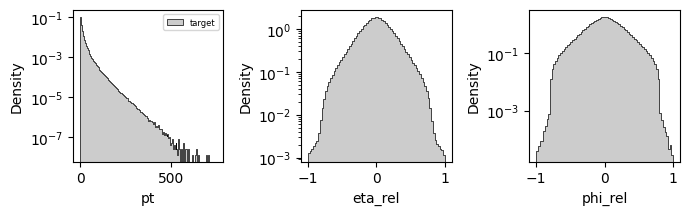

In [ ]:
import matplotlib.pyplot as plt

mask_target = (coupling.target.mask > 0).squeeze() 

fig, ax = plt.subplots(1,3, figsize=(7,2.25))

binrange, binwidth = (-5, 750), 5
coupling.target.histplot('pt', mask=mask_target, binwidth=binwidth, binrange=binrange, ax=ax[0], stat='density', log_scale=(False,True), lw=0.5, color='k', alpha=0.2, label='target')
binrange, binwidth = (-1,1), 0.025
coupling.target.histplot('eta_rel', mask=mask_target,  binwidth=binwidth, binrange=binrange, ax=ax[1], stat='density', log_scale=(False,True),  lw=0.5, color='k', alpha=0.2, label='target')
coupling.target.histplot('phi_rel', mask=mask_target, binwidth=binwidth, binrange=binrange, ax=ax[2], stat='density',log_scale=(False,True),  lw=0.5, color='k', alpha=0.2, label='target')
ax[0].legend(fontsize=6)
plt.tight_layout()
plt.show()

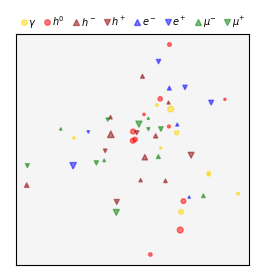

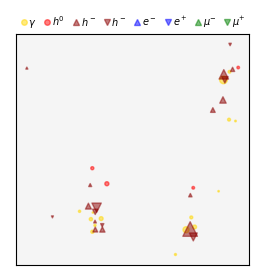

In [ ]:
coupling.source.display_cloud(idx=10,  scale_marker=10.0)
coupling.target.display_cloud(idx=10,  scale_marker=1.0)

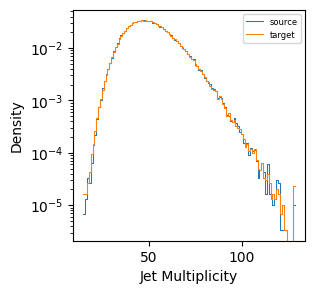

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

fig,ax = plt.subplots(1,1,figsize=(3,3))
sns.histplot(coupling.source.multiplicity, element="step", fill=False, discrete=True, lw=0.75, stat='density', log_scale=(False, True),  ax=ax, label='source')
sns.histplot(coupling.target.multiplicity, element="step", fill=False, discrete=True, lw=0.75, stat='density', log_scale=(False, True),  ax=ax, label='target')
ax.legend(fontsize=6)
ax.set_xlabel('Jet Multiplicity')
plt.show()

### Preprocessed data (standardization)

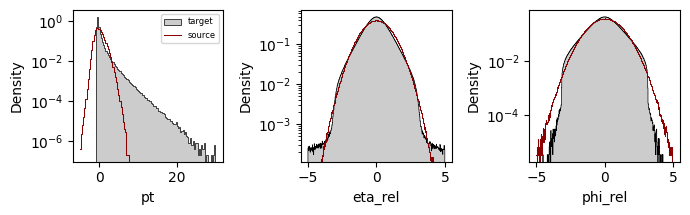

In [ ]:
stats_source = coupling.source.summary_stats()
stats_target = coupling.target.summary_stats()

coupling.source.preprocess(stats_source)
coupling.target.preprocess(stats_target)

mask_target = (coupling.target.mask > 0).squeeze() 
mask_source = (coupling.source.mask > 0).squeeze() 

import matplotlib.pyplot as plt

fig, ax = plt.subplots(1,3, figsize=(7,2.25))

binrange, binwidth = (-5, 30), 0.3
coupling.target.histplot('pt', mask=mask_target, binwidth=binwidth, binrange=binrange, ax=ax[0], stat='density', log_scale=(False,True), lw=0.5, color='k', alpha=0.2, label='target')
coupling.source.histplot('pt', mask=mask_source, binwidth=binwidth, binrange=binrange, ax=ax[0], stat='density',  log_scale=(False,True), color='darkred', fill=False, lw=0.75, label='source')

binrange, binwidth = (-5, 5), 0.02
coupling.target.histplot('eta_rel', mask=mask_target,  binwidth=binwidth, binrange=binrange, ax=ax[1], stat='density', log_scale=(False,True),  lw=0.5, color='k', alpha=0.2, label='target')
coupling.source.histplot('eta_rel', mask=mask_source, binwidth=binwidth, binrange=binrange, ax=ax[1], stat='density', log_scale=(False,True),  color='darkred', fill=False, lw=0.75, label='source')
coupling.target.histplot('phi_rel', mask=mask_target, binwidth=binwidth, binrange=binrange, ax=ax[2], stat='density', log_scale=(False,True), lw=0.5, color='k', alpha=0.2, label='target')
coupling.source.histplot('phi_rel', mask=mask_source, binwidth=binwidth, binrange=binrange, ax=ax[2], stat='density', log_scale=(False,True),  color='darkred', fill=False, lw=0.75, label='source')
ax[0].legend(fontsize=6)
plt.tight_layout()
plt.show()


## Generate data from pretrained model

In [ ]:
from cmb.models.trainers import GenerativeDynamicsModule
path='/home/df630/CMB/results/runs/JetClass/gauss_to_tbqq_FlowMatching_TelegraphProcess_HybridEPiC_2024.10.06_03h08_480/config.yaml'
epic_cmb = GenerativeDynamicsModule(config=path, device='cuda:1')
epic_cmb.load(checkpoint='best')

2024-10-07 00:16:32.227445: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-10-07 00:16:32.271295: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-10-07 00:16:32.272290: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-10-07 00:16:33.007192: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


INFO: Conditional Markov Bridge initialized...
      - continuous process:  FlowMatching
      - discrete process:  TelegraphProcess
      - solver method:  EulerLeapingSolver
INFO: loading `best` epoch checkpoint on cuda:1 from:
  - /home/df630/CMB/results/runs/JetClass/gauss_to_tbqq_FlowMatching_TelegraphProcess_HybridEPiC_2024.10.06_03h08_480/best_epoch.ckpt


In [ ]:
from cmb.datasets.jetclass import JetsClassData, ParticleClouds

epic_cmb.config.data.source.test.num_jets = 10000

source_stats = epic_cmb.config.data.source.train.stats.to_dict()
target_stats = epic_cmb.config.data.target.train.stats.to_dict()

test = JetsClassData(epic_cmb.config.data, task='test')
test.source.preprocess(source_stats)

epic_cmb.generate(source_continuous=test.source.continuous, 
                  source_discrete=test.source.discrete,
                  mask=test.source.mask,
                  output_history=False
                )

INFO: Loading test datasets.
INFO: generating samples...


In [ ]:
from cmb.datasets.jetclass import JetClassHighLevelFeatures, ParticleClouds

gen_sample = ParticleClouds(epic_cmb.sample, min_num_particles=0, max_num_particles=128, discrete_features=True) 
gen_sample.postprocess(target_stats)

gen_jets = JetClassHighLevelFeatures(gen_sample)
test_jets = JetClassHighLevelFeatures(test.target)


Clustering jets with fastjet
Jet definition: Longitudinally invariant kt algorithm with R = 0.8 and E scheme recombination
#--------------------------------------------------------------------------
#                         FastJet release 3.4.1
#                 M. Cacciari, G.P. Salam and G. Soyez                  
#     A software package for jet finding and analysis at colliders      
#                           http://fastjet.fr                           
#	                                                                      
# Please cite EPJC72(2012)1896 [arXiv:1111.6097] if you use this package
# for scientific work and optionally PLB641(2006)57 [hep-ph/0512210].   
#                                                                       
# FastJet is provided without warranty under the GNU GPL v2 or higher.  
# It uses T. Chan's closest pair algorithm, S. Fortune's Voronoi code,
# CGAL and 3rd party plugin jet algorithms. See COPYING file for details.
#-----------------------

Calculating D2
Clustering jets with fastjet
Jet definition: Longitudinally invariant kt algorithm with R = 0.8 and E scheme recombination
Calculating N-subjettiness
Calculating D2


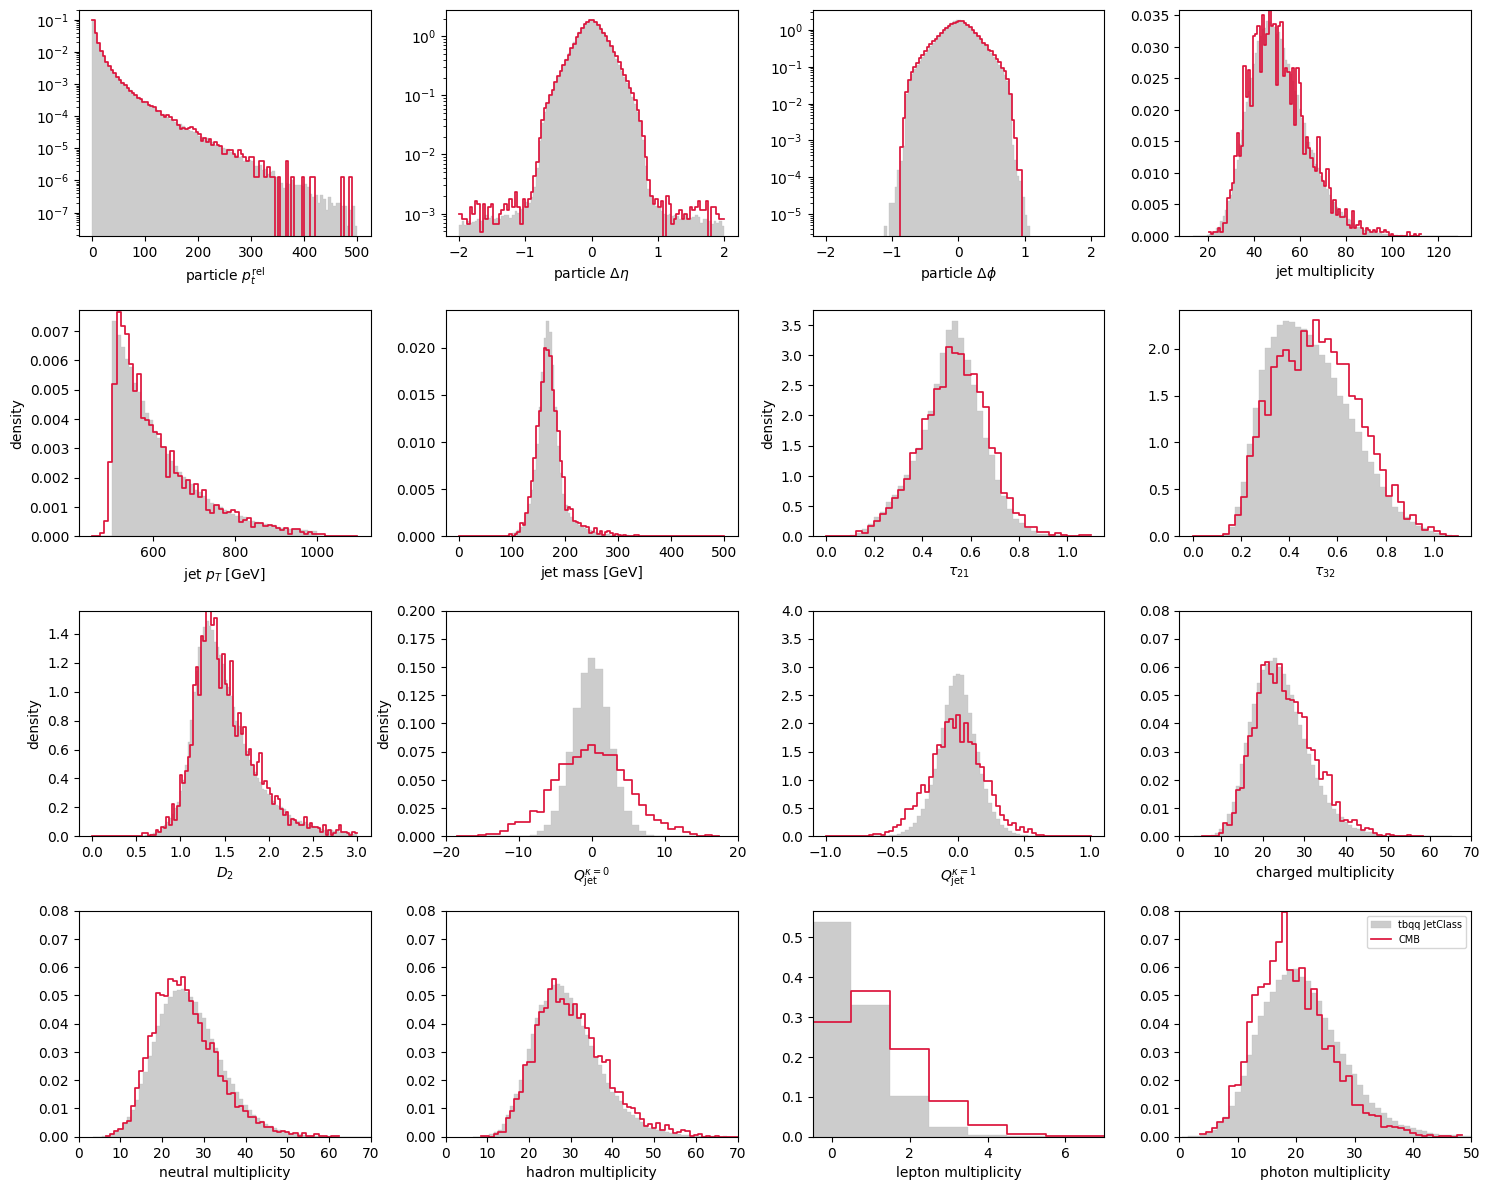

In [14]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

_, ax = plt.subplots(4,4,figsize=(15,12))

arg_test = dict(stat='density', fill=True, alpha=0.8, log_scale=(False, False), color='silver', lw=0.25, label='tbqq JetClass')
arg_gen = dict(stat='density', fill=False,log_scale=(False, False), color='crimson', lw=1.25,  label='CMB')
arg_test_log = dict(stat='density', fill=True, alpha=0.8, log_scale=(False, True), color='silver', lw=0.25, label='tbqq JetClass')
arg_gen_log = dict(stat='density', fill=False,log_scale=(False, True), color='crimson', lw=1.25,  label='CMB')


mask_gen = (gen_jets.constituents.mask > 0).squeeze() 
mask_test = (test_jets.constituents.mask > 0).squeeze() 

binrange, binwidth = (0, 500), 5
test_jets.constituents.histplot('pt', mask=mask_test,  binrange=binrange, binwidth=binwidth, xlabel=r'particle $p_t^{\rm rel}$', ax=ax[0,0], **arg_test_log)
gen_jets.constituents.histplot('pt', mask=mask_gen, binrange=binrange, binwidth=binwidth, xlabel=r'particle $p_t^{\rm rel}$', ax=ax[0,0], **arg_gen_log)

binrange, binwidth = (-2, 2), 0.04
test_jets.constituents.histplot('eta_rel', mask=mask_test,  binrange=binrange, binwidth=binwidth, xlabel=r'particle $\Delta \eta$', ax=ax[0,1], **arg_test_log)
gen_jets.constituents.histplot('eta_rel', mask=mask_gen, binrange=binrange, binwidth=binwidth, xlabel=r'particle $\Delta \eta$', ax=ax[0,1], **arg_gen_log)

binrange, binwidth = (-2, 2), 0.04
test_jets.constituents.histplot('phi_rel', mask=mask_test,  binrange=binrange, binwidth=binwidth, xlabel=r'particle $\Delta \phi$', ax=ax[0,2], **arg_test_log)
gen_jets.constituents.histplot('phi_rel', mask=mask_gen, binrange=binrange, binwidth=binwidth, xlabel=r'particle $\Delta \phi$', ax=ax[0,2], **arg_gen_log)


test_jets.histplot_multiplicities(xlabel='jet multiplicity', ax=ax[0,3], **arg_test)
gen_jets.histplot_multiplicities(xlabel='jet multiplicity', ax=ax[0,3], **arg_gen)

# ------------------------------

binrange, binwidth = (450, 1100), 10
test_jets.histplot('pt',  xlabel=r'jet $p_T$ [GeV]', ylabel='density', ax=ax[1,0], binrange=binrange, binwidth=binwidth, **arg_test)
gen_jets.histplot('pt', xlabel=r'jet $p_T$ [GeV]', ylabel='density', ax=ax[1,0], binrange=binrange, binwidth=binwidth, **arg_gen)

binrange, binwidth = (0, 500), 5
test_jets.histplot('m',  xlabel=r'jet mass [GeV]', ax=ax[1,1], binrange=binrange, binwidth=binwidth, **arg_test)
gen_jets.histplot('m', xlabel=r'jet mass [GeV]', ax=ax[1,1], binrange=binrange, binwidth=binwidth, **arg_gen)

binrange, binwidth, ylim = (0, 1.1), 0.025, (0, 4.0)
test_jets.histplot('tau21',  xlabel=r'$\tau_{21}$', ylabel='density', ax=ax[1,2], binrange=binrange, binwidth=binwidth, **arg_test)
gen_jets.histplot('tau21', xlabel=r'$\tau_{21}$', ylabel='density', ax=ax[1,2], binrange=binrange, binwidth=binwidth, **arg_gen)

test_jets.histplot('tau32',  xlabel=r'$\tau_{32}$', ax=ax[1,3], binrange=binrange, binwidth=binwidth, **arg_test)
gen_jets.histplot('tau32', xlabel=r'$\tau_{32}$', ax=ax[1,3], binrange=binrange, binwidth=binwidth, **arg_gen)


# ------------------------------

binrange, binwidth, ylim = (0, 3.0), 0.03, (0, 4.0)
test_jets.histplot('d2',  xlabel=r'$D_2$', ylabel='density', ax=ax[2,0], binrange=binrange, binwidth=binwidth, **arg_test)
gen_jets.histplot('d2', xlabel=r'$D_2$', ylabel='density', ax=ax[2,0], binrange=binrange, binwidth=binwidth, **arg_gen)

xlim, ylim = (-20, 20), (0, 0.2)
test_jets.histplot('Q_total', xlabel=r'$Q_{\rm jet}^{\kappa=0}$',  discrete=True, ax=ax[2,1], **arg_test)
gen_jets.histplot('Q_total', xlabel=r'$Q_{\rm jet}^{\kappa=0}$', ylim=ylim, xlim=xlim, ylabel='density', discrete=True, ax=ax[2,1], **arg_gen)

binrange, binwidth, ylim = (-1, 1), 0.03, (0.0, 4.0)
test_jets.histplot('Q_jet', xlabel=r'$Q_{\rm jet}^{\kappa=1}$', binrange=binrange, binwidth=binwidth , ax=ax[2,2], **arg_test)
gen_jets.histplot('Q_jet', xlabel=r'$Q_{\rm jet}^{\kappa=1}$', ylim=ylim, binrange=binrange, binwidth=binwidth, ax=ax[2,2], **arg_gen)

xlim, ylim = (0, 70), (0, 0.08)
test_jets.histplot_multiplicities(state=[2,3,4,5,6,7], xlabel='charged multiplicity', ax=ax[2,3], **arg_test)
gen_jets.histplot_multiplicities(state=[2,3,4,5,6,7], xlabel='charged multiplicity', xlim=xlim, ylim=ylim, ax=ax[2,3], **arg_gen)

xlim, ylim = (0, 70), (0, 0.08)
test_jets.histplot_multiplicities(state=[0,1], xlabel='neutral multiplicity', ax=ax[3,0], **arg_test)
gen_jets.histplot_multiplicities(state=[0,1], xlabel='neutral multiplicity', xlim=xlim, ylim=ylim, ax=ax[3,0], **arg_gen)

xlim, ylim = (0, 70), (0, 0.08)
test_jets.histplot_multiplicities(state=[1,2,3], xlabel='hadron multiplicity', ax=ax[3,1], **arg_test)
gen_jets.histplot_multiplicities(state=[1,2,3], xlabel='hadron multiplicity', xlim=xlim, ylim=ylim, ax=ax[3,1], **arg_gen)

xlim = (-0.5,7)
test_jets.histplot_multiplicities(state=[4,5,6,7], xlabel='lepton multiplicity', ax=ax[3,2], **arg_test)
gen_jets.histplot_multiplicities(state=[4,5,6,7], xlabel='lepton multiplicity', xlim=xlim, ax=ax[3,2], **arg_gen)   

xlim, ylim = (0, 50), (0, 0.08)
test_jets.histplot_multiplicities(state=0, xlabel='photon multiplicity', ax=ax[3,3], **arg_test)
gen_jets.histplot_multiplicities(state=0, xlabel='photon multiplicity', xlim=xlim, ylim=ylim, ax=ax[3,3], **arg_gen)

plt.legend(fontsize=7)

plt.tight_layout()
plt.savefig(epic_cmb.workdir / 'all_features.png')
plt.show()

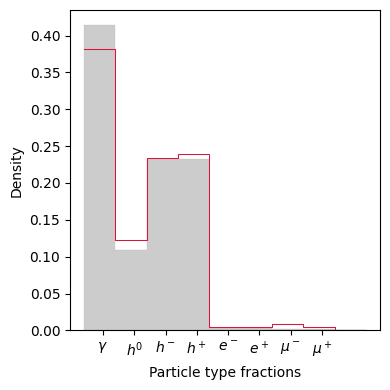

In [10]:
_, ax = plt.subplots(1,1,figsize=(4,4))

sns.histplot(test_jets.constituents.discrete[mask_test].squeeze(), binrange=(-0.1, 7.1), element='step',  ax=ax, discrete=True, **arg_test)
sns.histplot(gen_jets.constituents.discrete[mask_gen].squeeze(), binrange=(-0.1, 7.1), element='step', ax=ax, discrete=True, **arg_gen)
ax.set_xlabel('Particle type fractions')
ax.set_xticks(np.arange(8))
ax.set_xticklabels([r'$\gamma$', r'$h^0$', r'$h^-$', r'$h^+$', r'$e^-$', r'$e^+$', r'$\mu^-$', r'$\mu^+$'])

plt.tight_layout()
plt.savefig(epic_cmb.workdir / 'flavor_fractions.png')
plt.show()

In [ ]:
from utils import PlotModule
plots = PlotModule(generated_sample=sample, test_sample=test.target, postprocess=True)

NameError: name 'sample' is not defined

In [ ]:
plots.particle_kinematics(label='tbqq jetclass', save_path=epic_cmb.workdir)
plots.flavor_fractions(label='tbqq jetclass', save_path=epic_cmb.workdir)
plots.flavor_multiplicities(label='tbqq jetclass', save_path=epic_cmb.workdir)
plots.jet_total_Q(label='tbqq jetclass', save_path=epic_cmb.workdir)

## Metrics

In [ ]:
import torch
import seaborn as sns
from cmb.datasets.jetclass import JetsClassData, ParticleClouds
import awkward as ak
import fastjet
import vector
import scipy


class JetClassHighLevelFeatures:
    def __init__(self, constituents: ParticleClouds):

        self.constituents = constituents

        #...compute jet kinematics:
        self.constituents.compute_4mom()
        self.px = self.constituents.px.sum(axis=-1)
        self.py = self.constituents.py.sum(axis=-1)
        self.pz = self.constituents.pz.sum(axis=-1)
        self.e = self.constituents.e.sum(axis=-1)
        self.pt = torch.clamp_min(self.px**2 + self.py**2, 0).sqrt()
        self.m = torch.clamp_min(self.e**2 - self.px**2 - self.py**2 - self.pz**2, 0).sqrt()
        self.eta = 0.5 * torch.log((self.pt + self.pz) / (self.pt - self.pz))
        self.phi = torch.atan2(self.py, self.px)

        # discrete jet features
        self.constituents.get_flavor_charge_representation()
        self.Q_total = self.jet_charge(kappa=0.0)
        self.Q_jet = self.jet_charge(kappa=1.0)
        self.multiplicity = torch.sum(self.constituents.mask, dim=1)

        #...subsstructure
        self.R = 0.8
        self.beta = 1.0
        self.use_wta_scheme = False
        self.substructure()

    def histplot(self, features='pt', xlim=None, ylim=None, xlabel=None, ylabel=None, figsize=(3,3), ax=None, **kwargs):
        x = getattr(self, features)
        if isinstance(x, torch.Tensor): x.cpu().numpy()
        if ax is None: 
            _, ax = plt.subplots(figsize=figsize)   
        sns.histplot(x=x, element="step", ax=ax, **kwargs) 
        ax.set_xlabel(features if xlabel is None else xlabel)
        ax.set_ylabel(ylabel)
        ax.set_xlim(xlim)
        ax.set_ylim(ylim)

    def jet_charge(self, kappa):
        ''' jet charge defined as Q_j^kappa = Sum_i Q_i * (pT_i / pT_jet)^kappa
        '''
        Qjet = self.constituents.charge * (self.constituents.pt)**kappa
        return Qjet.sum(axis=1) / (self.pt**kappa) 
    
    def histplot_multiplicities(self, state=None, xlim=None, ylim=None, xlabel=None, ylabel=None, figsize=(3,3), ax=None, **kwargs):
        if state is not None:
            if isinstance(state, int):
                state = [state]
            multiplicity = torch.zeros(self.constituents.discrete.shape[0], 1)
            for s in state:
                x = (self.constituents.discrete == s) * self.constituents.mask
                multiplicity += x.sum(dim=1)
        else:
            multiplicity = self.multiplicity

        if ax is None: 
            _, ax = plt.subplots(figsize=figsize)   
        sns.histplot(x=multiplicity.squeeze(-1), element="step", ax=ax, discrete=True, **kwargs) 
        ax.set_xlabel(xlabel)
        ax.set_ylabel(ylabel)
        ax.set_xlim(xlim)
        ax.set_ylim(ylim)

    def flavor_fractions(self, figsize=(3,3), ax=None, **kwargs):
        if ax is None: 
            _, ax = plt.subplots(figsize=figsize)                                          
        sns.histplot(self.constituents.discrete[self.constituents.mask].squeeze(), binrange=(-0.1, 7.1), element="step", ax=ax, discrete=True, **kwargs)
        ax.legend(loc='upper right', fontsize=7)
        ax.set_xlabel('Particle flavor')
        ax.set_xticks(np.arange(8))
        ax.set_xticklabels([r'$\gamma$', r'$h^0$', r'$h^-$', r'$h^+$', r'$e^-$', r'$e^+$', r'$\mu^-$', r'$\mu^+$'])

    def substructure(self):

        constituents_ak = ak.zip({ "pt": np.array(self.constituents.pt),
                                   "eta": np.array(self.constituents.eta_rel),
                                   "phi": np.array(self.constituents.phi_rel),
                                   "mass": np.zeros_like(np.array(self.constituents.pt))
                                   },
                                  with_name="Momentum4D")

        constituents_ak = ak.mask(constituents_ak, constituents_ak.pt > 0)
        constituents_ak = ak.drop_none(constituents_ak)
        self.constituents_ak = constituents_ak[ak.num(constituents_ak) >= 3]
        if self.use_wta_scheme:
            jetdef = fastjet.JetDefinition(fastjet.kt_algorithm, self.R, fastjet.WTA_pt_scheme)
        else:
            jetdef = fastjet.JetDefinition(fastjet.kt_algorithm, self.R)
        print("Clustering jets with fastjet")
        print("Jet definition:", jetdef)
        self.cluster = fastjet.ClusterSequence(constituents_ak, jetdef)
        self.inclusive_jets = self.cluster.inclusive_jets()
        self.exclusive_jets_1 = self.cluster.exclusive_jets(n_jets=1)
        self.exclusive_jets_2 = self.cluster.exclusive_jets(n_jets=2)
        self.exclusive_jets_3 = self.cluster.exclusive_jets(n_jets=3)
        print("Calculating N-subjettiness")
        self._calc_d0()
        self._calc_tau1()
        self._calc_tau2()
        self._calc_tau3()
        self.tau21 = np.ma.divide(self.tau2, self.tau1)
        self.tau32 = np.ma.divide(self.tau3, self.tau2)
        print("Calculating D2")
        # D2 as defined in https://arxiv.org/pdf/1409.6298.pdf
        self.d2 = self.cluster.exclusive_jets_energy_correlator(njets=1, func="d2")

    def _calc_deltaR(self, particles, jet):
        jet = ak.unflatten(ak.flatten(jet), counts=1)
        return particles.deltaR(jet)

    def _calc_d0(self):
        """Calculate the d0 values."""
        self.d0 = ak.sum(self.constituents_ak.pt * self.R**self.beta, axis=1)

    def _calc_tau1(self):
        """Calculate the tau1 values."""
        self.delta_r_1i = self._calc_deltaR(self.constituents_ak, self.exclusive_jets_1[:, :1])
        self.pt_i = self.constituents_ak.pt
        self.tau1 = ak.sum(self.pt_i * self.delta_r_1i**self.beta, axis=1) / self.d0

    def _calc_tau2(self):
        """Calculate the tau2 values."""
        delta_r_1i = self._calc_deltaR(self.constituents_ak, self.exclusive_jets_2[:, :1])
        delta_r_2i = self._calc_deltaR(self.constituents_ak, self.exclusive_jets_2[:, 1:2])
        self.pt_i = self.constituents_ak.pt
        # add new axis to make it broadcastable
        min_delta_r = ak.min(
            ak.concatenate(
                [
                    delta_r_1i[..., np.newaxis] ** self.beta,
                    delta_r_2i[..., np.newaxis] ** self.beta,
                ],
                axis=-1,
            ),
            axis=-1,
        )
        self.tau2 = ak.sum(self.pt_i * min_delta_r, axis=1) / self.d0

    def _calc_tau3(self):
        """Calculate the tau3 values."""
        delta_r_1i = self._calc_deltaR(self.constituents_ak, self.exclusive_jets_3[:, :1])
        delta_r_2i = self._calc_deltaR(self.constituents_ak, self.exclusive_jets_3[:, 1:2])
        delta_r_3i = self._calc_deltaR(self.constituents_ak, self.exclusive_jets_3[:, 2:3])
        self.pt_i = self.constituents_ak.pt
        min_delta_r = ak.min(
            ak.concatenate(
                [
                    delta_r_1i[..., np.newaxis] ** self.beta,
                    delta_r_2i[..., np.newaxis] ** self.beta,
                    delta_r_3i[..., np.newaxis] ** self.beta,
                ],
                axis=-1,
            ),
            axis=-1,
        )
        self.tau3 = ak.sum(self.pt_i * min_delta_r, axis=1) / self.d0

    def histogram(self, features='pt', density=True, num_bins=100, use_quantiles=False):
        x = getattr(self, features)
        bins = np.quantile(x, np.linspace(0.001, 0.999, num_bins)) if use_quantiles else num_bins
        return np.histogram(x, density=density, bins=bins)[0]

    def KLmetric1D(self, feature, reference, num_bins=100, use_quantiles=True):
        h1 = self.histogram(feature, density=True, num_bins=num_bins, use_quantiles=use_quantiles) + 1e-8
        h2 = reference.histogram(feature, density=True, num_bins=num_bins, use_quantiles=use_quantiles) + 1e-8
        return scipy.stats.entropy(h1, h2)  

    def Wassertein1D(self, feature, reference):
        x = getattr(self, feature)
        y = getattr(reference, feature)
        return scipy.stats.wasserstein_distance(x, y)
    




In [ ]:
jets = JetClassHighLevelFeatures(coupling.target)
noise = JetClassHighLevelFeatures(coupling.source)



_, ax = plt.subplots(2,4,figsize=(11,5))

xlim = (-50, 50)
jets.histplot('Q_total', xlabel=r'$Q_{\rm jet}^{\kappa=0}$',  discrete=True, ax=ax[0,0], stat='density', fill=True, alpha=0.4, log_scale=(False, True), lw=0.75, label='target')
noise.histplot('Q_total', xlabel=r'$Q_{\rm jet}^{\kappa=0}$', xlim=xlim, ylabel='density', discrete=True, ax=ax[0,0], stat='density', fill=True, alpha=0.4, log_scale=(False, True), lw=0.75, label='source')

binrange, binwidth, = (-5, 5), 0.05
jets.histplot('Q_jet', xlabel=r'$Q_{\rm jet}^{\kappa=1}$', binrange=binrange, binwidth=binwidth , ax=ax[0,1], stat='density', fill=True, alpha=0.4, log_scale=(False, True), lw=0.75, label='target')
noise.histplot('Q_jet', xlabel=r'$Q_{\rm jet}^{\kappa=1}$', binrange=binrange, binwidth=binwidth, ax=ax[0,1], stat='density', fill=True, alpha=0.4, log_scale=(False, True), lw=0.75, label='source')

jets.histplot_multiplicities(xlabel='jet multiplicity', ax=ax[0,2], stat='density', fill=True, alpha=0.4, log_scale=(False, False), lw=0.75, label='target')
noise.histplot_multiplicities(xlabel='jet multiplicity', ax=ax[0,2], stat='density', fill=True, alpha=0.4, log_scale=(False, False), lw=0.75, label='source')

xlim, ylim = (0, 70), (0, 0.12)
jets.histplot_multiplicities(state=[2,3,4,5,6,7], xlabel='charged multiplicity', ax=ax[0,3], stat='density', fill=True, alpha=0.4, log_scale=(False, False), lw=0.75, label='target')
noise.histplot_multiplicities(state=[2,3,4,5,6,7], xlabel='charged multiplicity', xlim=xlim, ylim=ylim, ax=ax[0,3], stat='density', fill=True, alpha=0.4, log_scale=(False, False), lw=0.75, label='source')

xlim, ylim = (0, 70), (0, 0.12)
jets.histplot_multiplicities(state=[0,1], xlabel='neutral multiplicity', ax=ax[1,0], stat='density', fill=True, alpha=0.4, log_scale=(False, False), lw=0.75, label='target')
noise.histplot_multiplicities(state=[0,1], xlabel='neutral multiplicity', xlim=xlim, ylim=ylim, ax=ax[1,0], stat='density', fill=True, alpha=0.4, log_scale=(False, False), lw=0.75, label='source')

xlim, ylim = (0, 70), (0, 0.08)
jets.histplot_multiplicities(state=[1,2,3], xlabel='hadron multiplicity', ax=ax[1,1], stat='density', fill=True, alpha=0.4, log_scale=(False, False), lw=0.75, label='target')
noise.histplot_multiplicities(state=[1,2,3], xlabel='hadron multiplicity', xlim=xlim, ylim=ylim, ax=ax[1,1], stat='density', fill=True, alpha=0.4, log_scale=(False, False), lw=0.75, label='source')

xlim = (0,50)
jets.histplot_multiplicities(state=[4,5,6,7], xlabel='lepton multiplicity', ax=ax[1,2], stat='density', fill=True, alpha=0.4, log_scale=(False, False), lw=0.75, label='target')
noise.histplot_multiplicities(state=[4,5,6,7], xlabel='lepton multiplicity', xlim=xlim, ax=ax[1,2], stat='density', fill=True, alpha=0.4, log_scale=(False, False), lw=0.75, label='source')

xlim, ylim = (0, 50), (0, 0.2)
jets.histplot_multiplicities(state=0, xlabel='photon multiplicity', ax=ax[1,3], stat='density', fill=True, alpha=0.4, log_scale=(False, False), lw=0.75, label='target')
noise.histplot_multiplicities(state=0, xlabel='photon multiplicity', xlim=xlim, ylim=ylim, ax=ax[1,3], stat='density', fill=True, alpha=0.4, log_scale=(False, False), lw=0.75, label='source')

ax[0,0].legend(fontsize=7)
plt.tight_layout()
plt.show()

NameError: name 'coupling' is not defined

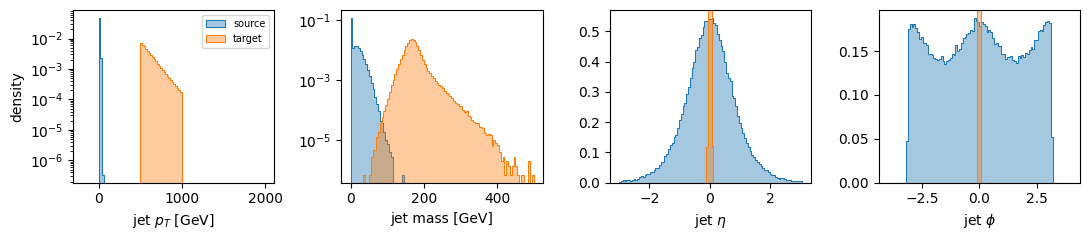

In [ ]:
_, ax = plt.subplots(1,4,figsize=(11,2.5))

binrange, binwidth = (-200, 2000), 20
noise.histplot('pt',  xlabel=r'jet $p_T$ [GeV]', ylabel='density', ax=ax[0], binrange=binrange, binwidth=binwidth, stat='density', fill=True, alpha=0.4, log_scale=(False, True), lw=0.75, label='source')
jets.histplot('pt', xlabel=r'jet $p_T$ [GeV]', ylabel='density', ax=ax[0], binrange=binrange, binwidth=binwidth, stat='density', fill=True, alpha=0.4, log_scale=(False, True), lw=0.75,  label='target')

binrange, binwidth = (0, 500), 5
noise.histplot('m',  xlabel=r'jet mass [GeV]', ax=ax[1], binrange=binrange, binwidth=binwidth, stat='density', fill=True, alpha=0.4, log_scale=(False, True),  lw=0.75, label='source')
jets.histplot('m', xlabel=r'jet mass [GeV]', ax=ax[1], binrange=binrange, binwidth=binwidth, stat='density', fill=True, alpha=0.4, log_scale=(False, True), lw=0.75,  label='target')

binrange, binwidth = (-3, 3), 0.06
noise.histplot('eta',  xlabel=r'jet $\eta$', ax=ax[2], binrange=binrange, binwidth=binwidth, stat='density', fill=True, alpha=0.4, log_scale=(False, False),  lw=0.75, label='source')
jets.histplot('eta', xlabel=r'jet $\eta$', ax=ax[2], binrange=binrange, binwidth=binwidth, stat='density', fill=True, alpha=0.4, log_scale=(False, False), lw=0.75,  label='target')

binrange, binwidth = (-4, 4), 0.08
noise.histplot('phi',  xlabel=r'jet $\phi$', ax=ax[3], binrange=binrange, binwidth=binwidth, stat='density', fill=True, alpha=0.4, log_scale=(False, False), lw=0.75, label='source')
jets.histplot('phi', xlabel=r'jet $\phi$', ax=ax[3], binrange=binrange, binwidth=binwidth, stat='density', fill=True, alpha=0.4, log_scale=(False, False), lw=0.75,  label='target')
ax[0].legend(fontsize=7)
plt.tight_layout()
plt.show()